# AR(1) - Auto-correlation tracking

In this notebook, I would like to show the power of the Kalman filter for tracking hidden variables.    

In the notebook **5.1** I introduced the Kalman algorithm and applied it to real financial data. However, it was not possible to verify the goodness of the algorithm (by computing the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) for instance). In the present notebook, I prefer to work with a simulated time series, where the hidden state process (the $\rho$ or $\beta$ process) is known!

## Contents
   - [Autoregressive process AR(1)](#sec1)
      - [Regression analysis](#sec1.1)
   - [Kalman filter](#sec2)
   - [Non-constant autocorrelation](#sec3)
      - [Example 1](#sec3.1)
      - [Example 2](#sec3.2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_model as sml
import scipy as scp
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from patsy import dmatrices
import functions.Kalman_filter as KF

<a id='sec1'></a>
# Autoregressive process AR(1)

The AR(1) is the Auto-Regressive process of order 1 [wiki](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process).

$$ (X_t - \mu) = \phi (X_{t-1} - \mu) + \epsilon_t $$

where $\mu$ is the mean of $X_t$, and $t \in \mathbb{N}$. We also assume uncorrelated errors $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$.

The process can be written in the form of a linear regression, where the value of $X_t$ is modelled as a linear function of $X_{t-1}$:

$$ X_t = \alpha + \beta X_{t-1} + \epsilon_t $$

with $\beta = \phi$ and $\alpha = \mu (1-\phi)$.      
We also have to require that $\epsilon_t$ and $X_{t-1}$ are uncorrelated.
And impose the condition $|\phi|<1$, in order to have a stationary process.

- The ACF (Auto-Correlation Function) [wiki](https://en.wikipedia.org/wiki/Autocorrelation) is 

$$ \rho_k = \phi \rho_{k-1} = \phi^k \quad k \geq 1. $$

- The PACF (Partial Auto-Correlation Function) [wiki](https://en.wikipedia.org/wiki/Partial_autocorrelation_function), is

$$
\begin{aligned}
& \text{PACF}_{k} = \rho_1 = \phi& \quad \text{for} \quad k=1 \\
& \text{PACF}_{k} = 0 &\quad \text{for} \quad k\geq 2. 
\end{aligned}$$

An important thing to notice is the form of the autocorrelation coefficient with lag $k=1$:

$$ \rho_1 = \beta = \phi. $$ 

For simplicity I will assume $X_0 = 0$ and $\alpha=0$. Let us simulate the AR(1) process:

In [2]:
np.random.seed(seed=42) 
N = 1000                    # time steps
rho = 0.7                   # rho = beta = phi 
sigma = 0.1                 # std dev of epsilon

W = ss.norm.rvs(loc=0, scale=sigma, size=N)
W = W - W.mean()            # remove the mean

X_ar = np.zeros(N)
for i in range(N-1):
    X_ar[i+1] = rho * X_ar[i] + W[i+1]

We can estimate the parameters in the same way we do it for linear regressions. The following considered estimators are asymptotically unbiased.

In [3]:
Y = X_ar[1:]         # response
X = X_ar[:-1]        # predictor

bb, aa, _, _, _ = ss.linregress(X,Y)
print("beta=",bb," alpha=",aa)

beta= 0.6949272218592951  alpha= -4.9619437434945946e-05


##### Plots

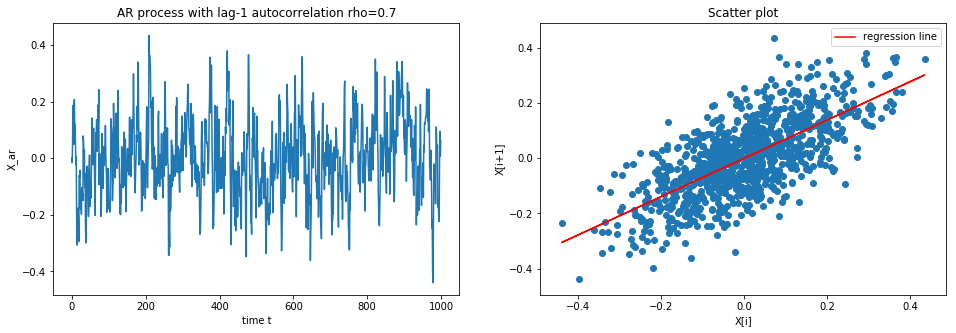

In [4]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(X_ar); ax1.set_xlabel("time t"); ax1.set_ylabel("X_ar")
ax1.set_title("AR process with lag-1 autocorrelation rho={}".format(rho))

ax2.scatter(X, Y); ax2.set_title("Scatter plot") 
ax2.plot(X, aa + bb*X, color="r", label="regression line"); ax2.legend()
ax2.set_xlabel("X[i]"); ax2.set_ylabel("X[i+1]"); plt.show()

<a id='sec1.1'></a>
## Regression analysis

### Autocorrelation 

In [5]:
print("Auto Correlation = ", np.corrcoef(Y,X)[0,1])

Auto Correlation =  0.6948575956471165


Let us compute and plot the ACF and PACF with lag $1 \leq k \leq 20$.       
The PACF can be computed in several methods (type `pacf??` in a new cell for more informations)
The parameter `alpha` is used for the confidence interval computation.

In [6]:
acf_theoretical = [ rho**i for i in range(21) ]         # theoretical values
pacf_theoretical = [1] + [rho] + 19*[0]                 # theoretical values
acf_20 = acf( X_ar, nlags=20, fft=False, alpha=0.05 )   # computes ACF not using FFT
pacf_20 = pacf( X_ar, nlags=20, alpha=0.05 )            # Computes pacf 

##### Plot made by me

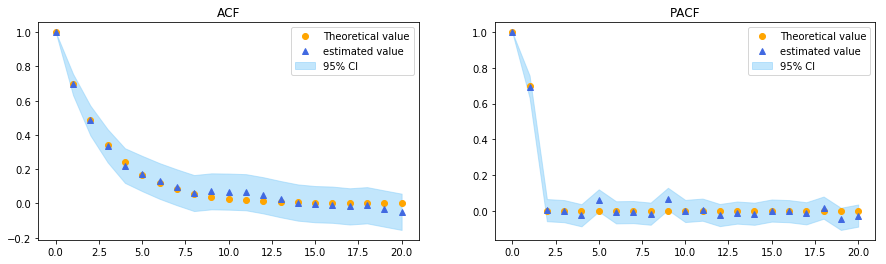

In [7]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(acf_theoretical, 'o', color="orange", label="Theoretical value")
ax1.plot(acf_20[0], '^', color="royalblue", label="estimated value")
ax1.fill_between(x=range(21) ,y1=acf_20[1][:,0], y2=acf_20[1][:,1], 
                 alpha=0.5, linewidth=1, color='lightskyblue', label="95% CI")
ax2.plot(pacf_theoretical, 'o', color="orange", label="Theoretical value")
ax2.plot(pacf_20[0], '^', color="royalblue", label="estimated value")
ax2.fill_between(x=range(21) ,y1=pacf_20[1][:,0], y2=pacf_20[1][:,1], 
                 alpha=0.5, linewidth=1, color='lightskyblue', label="95% CI")
ax1.set_title("ACF"); ax2.set_title("PACF"); ax1.legend(); ax2.legend(); plt.show()

The function `acf` uses the Bartlett's approximation for the computation of the standard error (necessary for the computation of confidence intervals). The formulas for the standard errors used in `acf` and `pacf` are:

$$ SE_{\rho_k} = \sqrt{\frac{1}{N} (1+2\rho_1^2 + ... + 2\rho_{k-1}) } 
\quad \text{and} \quad SE_{\text{pacf}} = \sqrt{\frac{1}{N}} $$

Alternatively, we can use the `statsmodels` functions:

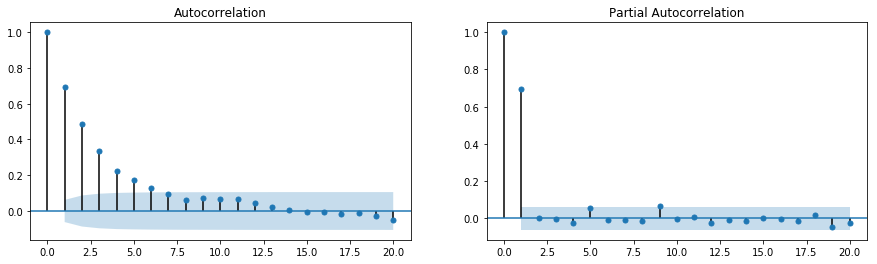

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
plot_acf(X_ar, lags=20, ax=axes[0])
plot_pacf(X_ar, lags=20, ax=axes[1])
plt.show()

### Estimation using statsmodels methods: OLS and ols

##### Method 1

In [9]:
X1 = sm.add_constant(X)                              # creates a column of only ones
results = sm.OLS(Y, X1).fit(method="pinv")           # OLS capital letters
print("alpha=", results.params[0], "beta=", results.params[1])

alpha= -4.96194374349447e-05 beta= 0.6949272218592947


##### Method 2

The library `statsmodels` lets you use *R-style* formulas to specify the regression parameters. This is very useful, in particular when working with multiple regression.    
The right method to call is `ols`, written with small letters.

In [10]:
df = pd.DataFrame({'X':Y, "X_lag":X})                               # dataframe
result = smf.ols(formula='X ~ X_lag', data=df).fit(method="qr")     # lowercase ols for R-style
print("alpha=", result.params[0], "beta=", result.params[1])

alpha= -4.961943743494303e-05 beta= 0.6949272218592953


##### Method 3
The same effect of `sm.add_constant` can be obtained with the `dmatrices` from the [patsy library](https://patsy.readthedocs.io/en/latest/). This function lets you create a regressors matrix by selecting the columns of a dataframe and using *R-style formulas* (for more information see [here](https://www.statsmodels.org/devel/example_formulas.html) ). This is the code to use: 

In [11]:
Y_m, X_m = dmatrices('X ~ X_lag', data=df, return_type='dataframe')         
result = sm.OLS(Y_m, X_m).fit()         
print(result.params) 

Intercept   -0.000050
X_lag        0.694927
dtype: float64


Note that we used again the function `sm.OLS` with capital letters. 

**Comment:**      
Regarding the [fit methods](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.fit.html), there are two possibilities:     
The OLS method for multiple linear regression returns an estimated vector $\beta$ that requires the computation of the inverse of a matrix [see here, wiki](https://en.wikipedia.org/wiki/Linear_least_squares).
-  pinv method: uses the [Moore-Penrose inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) 
-  qr method: uses the [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition)

### Estimation using ARMA class

##### Method 4

In [12]:
AR1 = sml.ARMA( X_ar, (1,0) ).fit(disp=0, method='mle')
print(AR1.params)
AR1 = sml.ARMA( X_ar, (1,0) ).fit(disp=0, method='css')
print(AR1.params)

[-1.62200920e-04  6.94234012e-01]
[-1.62648346e-04  6.94927268e-01]


Above I presented the results obtained by two different methods ([see here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.fit.html)):  
- MLE: Maximum-Likelihood-Estimation
- CSS: Conditional Sum of Squares

The first parameter above corresponds to what we previously called $\mu$ (the mean). We can calculate the regression intercept $\alpha$ by:

In [13]:
AR1.params[0] * (1-AR1.params[1])

-4.961957526413125e-05

<a id='sec2'></a>
# Kalman Filter

We are ready to add some noise to the coefficient $\rho$.


In [14]:
np.random.seed(seed=42) 
N = 1000                    # time steps
rho = 0.7                   # rho   
sig_mod = 0.02              # model error 
sig_meas = 0.2              # measure error

err = ss.norm.rvs(loc=0, scale=sig_mod, size=N-1)
err = err - err.mean()
W = ss.norm.rvs(loc=0, scale=sig_meas, size=N-1)
W = W - W.mean()
beta = rho + err

X_ar = np.zeros(N)
for i in range(N-1):
    X_ar[i+1] = beta[i] * X_ar[i] + W[i]

##### Plot of true rho and the rho with model errors

I used the name `beta` to call the "rho with model error".

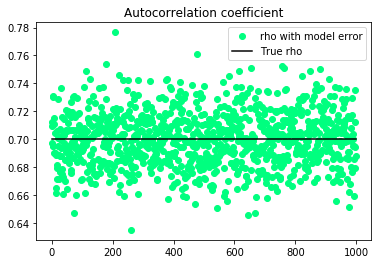

In [16]:
plt.plot(beta, color="springgreen", marker='o', linestyle="None", label="rho with model error")
plt.plot([rho]*N, color="black", alpha=2, label="True rho")
plt.title("Autocorrelation coefficient"); plt.legend(); plt.show()

Let us estimate the regression parameters:

In [17]:
Y = X_ar[1:]
X = X_ar[:-1]

bb, aa, _, _, _ = ss.linregress(X,Y)
print("beta=",bb," alpha=",aa)

beta= 0.6903260280287947  alpha= -9.444498070744538e-05


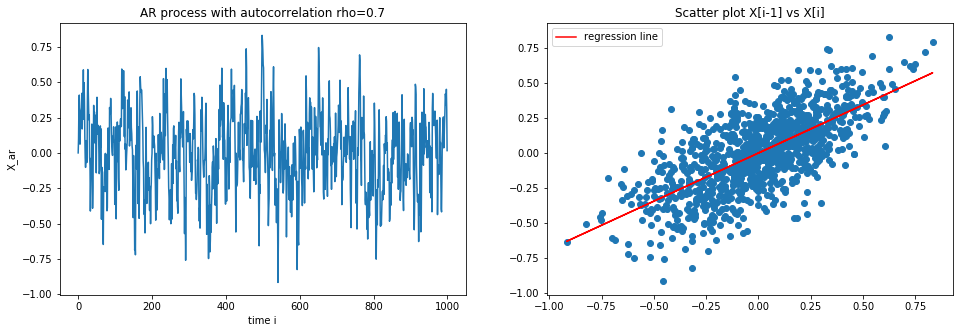

In [18]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(X_ar); ax1.set_xlabel("time i"); ax1.set_ylabel("X_ar")
ax1.set_title("AR process with autocorrelation rho={}".format(rho))
ax2.scatter(X, Y); ax2.set_title("Scatter plot X[i-1] vs X[i]") 
ax2.plot(X, aa + bb*X, color="r", label="regression line"); ax2.legend()
plt.show()

#### Train and Test sets

In [19]:
training_size = 499
X_train = X[:training_size] 
X_test = X[training_size:] 
Y_train = Y[:training_size] 
Y_test = Y[training_size:] 

beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(X_train, Y_train)
resid_tr = Y_train - beta_tr * X_train - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols)

In the training set the OLS estimators of
alpha_tr =  0.006482284097274513
beta_tr =  0.7067249394335238
var_eps =  0.041107269161106096


In [20]:
KF.calibrate_Kalman_MLE(X_train, Y_train, alpha_tr, beta_tr, var_eps_ols=var_eps_ols)

      fun: -85.80936401365838
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.77818094e+04, 1.70530257e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 7
   status: 0
  success: True
        x: array([9.99200722e-16, 4.10246346e-02])

Alright... **MLE method doesn't work here.**    
As discussed in the notebook **5.1**, sometimes the log-likelihood function assumes a maximum at 0. Unfortunately, this value is not reasonable. 

#### Window-dependent estimation:

In [21]:
rolling_window = 60
set_train_beta = []
for i in range( rolling_window, len(X_train) ):
    beta_temp,_ ,_ ,_ ,_  = ss.linregress( X[i-rolling_window : 1+i],
                                           Y[i-rolling_window : 1+i] )
    set_train_beta.append(beta_temp)
sig_eta = np.std(np.diff(set_train_beta))
print(sig_eta)

0.019619028124903674


The previous method is an informal method that helps to get an approximative value of the standard deviation.

Since the estimation of the process noise $\sigma_{\eta}$ is a difficult task, it is sometimes considered as part of the design of the filter. In this case, the designer has a strong responsibility, because his decisions will affect the performances of the filter.

#### Kalman filter application:

The last values of $\beta$ and $P$ in the training set are used as initial values for the Kalman filter in the test set.

In [22]:
var_eta = sig_eta**2
var_eps = var_eps_ols

In [23]:
_, beta_last, P_last = KF.Kalman_beta(X_train, Y_train, 
                                         0, beta_tr, var_eta, var_eps, 1, True)

print("beta_last = ", beta_last,"P_last = ", P_last)

betas_KF, Ps_KF = KF.Kalman_beta(X_test, Y_test, 0, beta_last, var_eta, var_eps, P_last)

beta_last =  0.7950510595851324 P_last =  0.011307228473208458


##### Rolling regression beta

In [24]:
rolling_window = 60
rolling_beta = KF.rolling_regression_test(X, Y, rolling_window, training_size) 

##### RTS Smoother

In the following cell I also calculate the [Rauch-Tung-Striebel](https://en.wikipedia.org/wiki/Kalman_filter#Rauch%E2%80%93Tung%E2%80%93Striebel) smoother. 

In [25]:
betas_smooth, Ps_smooth = KF.RTS_smoother(X_test, Y_test, 0, beta_last, var_eta, var_eps, P_last)

##### Plot of betas

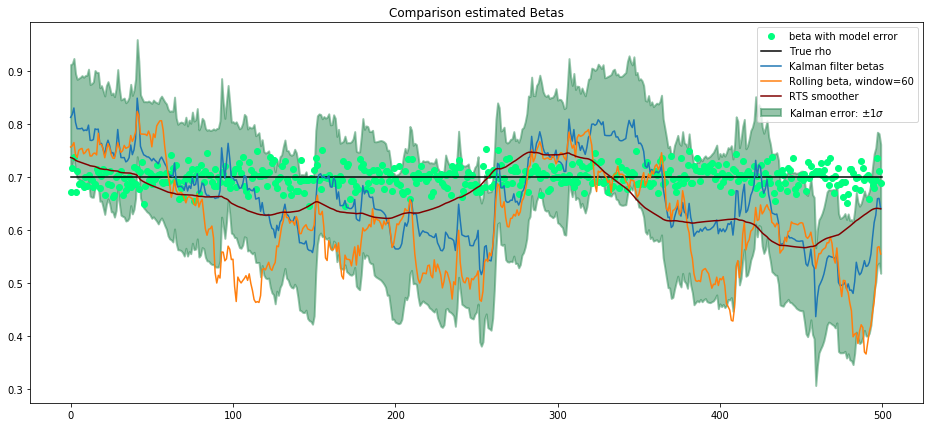

In [26]:
plt.figure(figsize=(16,7))
plt.plot(beta[training_size:], color="springgreen", marker='o', linestyle="None", 
         label="beta with model error")
plt.plot([rho]*(N-training_size), color="black", alpha=2, label="True rho")
plt.plot(betas_KF, label="Kalman filter betas")
plt.plot(rolling_beta, label="Rolling beta, window={}".format(rolling_window))
plt.plot(betas_smooth, label="RTS smoother", color="maroon")
plt.fill_between(x=range(len(betas_KF)) ,y1=betas_KF + np.sqrt(Ps_KF), y2=betas_KF - np.sqrt(Ps_KF), 
                 alpha=0.5, linewidth=2, color='seagreen', label="Kalman error: $\pm 1 \sigma$ ")
plt.legend(); plt.title("Comparison estimated Betas"); plt.show()

Let us compare the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error):

In [27]:
print("MSE Kalman Filter: ", np.mean((betas_KF - rho)**2) )
print("MSE Rolling regression: ", np.mean((np.array(rolling_beta) - rho)**2) )
print("MSE RTS Smoother: ", np.mean((betas_smooth - rho)**2) )

MSE Kalman Filter:  0.008143371400501585
MSE Rolling regression:  0.016595923897143535
MSE RTS Smoother:  0.004295501990194219


- As expected the RTS smoother has smaller MSE than the Filter output.
- When we compare the Rolling regression MSE with the Kalman MSE, we have to remember that the rolling betas depend on the window size! 

In this case, where the **true rho is constant**, the higher is the window used in the rolling regression, the smaller is the MSE.    
Below we will see that when the true rho is not constant, it is better to use a small window.

The Kalman estimator, instead, represents the spot value of beta. This value is however affected by the designer choice of the unkown parameter $\sigma_{\eta}$.    
Let us recall that a small process error $\sigma_{\eta}$ means that we are very confident in the model, and the filter will not be very sensitive to new measures.

<a id='sec3'></a>
# Non-constant Autocorrelation

In the previous section, we considered a constant true value of $\rho$. In this case, regression analysis works well and the results are quite satisfactory.    
But what happens if $\rho$ is a function of time?

In the next two examples, when we try to compute the autocorrelation coefficient of the process using the entire dataset, we will obtain just a constant "average value". But we will not be able to acquire knowledge of the spot autocorrelation value. 

In this section, we will see that the Kalman filter is a good solution for this problem! And can be a good alternative to the rolling regression approach.

<a id='sec3.1'></a>
## Example 1:   Smooth behavior

In [28]:
np.random.seed(seed=42) 
N = 1000
sig_mod2 = 0.02       # model error 
sig_meas2 = 0.2       # measure error

omega = 2 * np.pi / N                          # frequency
C = 0.8                                        # amplitude 
x = np.array(range(N))
rho_nc = C * np.sin( omega * x - np.pi/4)      # rho non constant

err2 = ss.norm.rvs(loc=0, scale=sig_mod2, size=N-1)
err2 = err2 - err2.mean()
W2 = ss.norm.rvs(loc=0, scale=sig_meas2, size=N-1)
W2 = W2 - W2.mean()
beta_nc = rho_nc[1:] + err2                     # rho + noise

X_ar2 = np.zeros(N)
for i in range(N-1):
    X_ar2[i+1] = beta_nc[i] * X_ar2[i] + W2[i]

Y = X_ar2[1:]
X = X_ar2[:-1]

bb, aa, _, _, _ = ss.linregress(X,Y)
print("beta=",bb," alpha=",aa)
print("Auto Correlation = ", np.corrcoef(Y,X)[0,1])

beta= 0.052184865915345456  alpha= -0.0014587952488626101
Auto Correlation =  0.05217948119999299


The auto-correlation computed above is not informative of the real auto-correlation dynamics.    
The two plots below show the true dynamics of $\rho$ (left), and the bad estimation of the regression line with slope computed above (right). 

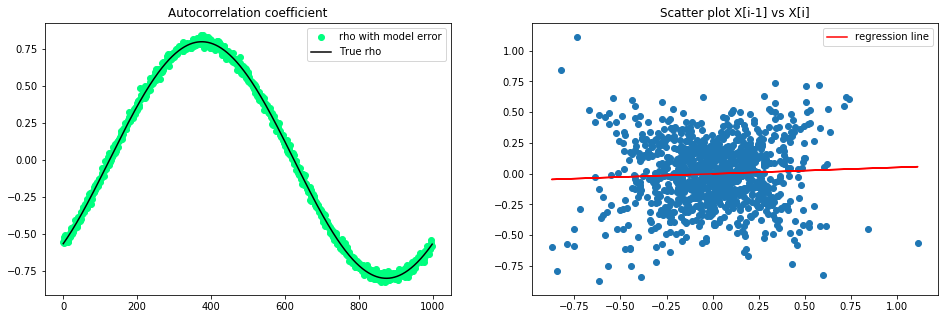

In [30]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(beta_nc, color="springgreen", marker='o', linestyle="None", 
         label="rho with model error")
ax1.plot(x, rho_nc, color="black", alpha=2, label="True rho")
ax1.legend(); ax1.set_title("Autocorrelation coefficient") 
ax2.scatter(X, Y); ax2.set_title("Scatter plot X[i-1] vs X[i]") 
ax2.plot(X, aa + bb*X, color="r", label="regression line"); ax2.legend()
plt.show()

#### Train-Test split. 


In [31]:
training_size = 400
X_train = X[:training_size] 
X_test = X[training_size:] 
Y_train = Y[:training_size] 
Y_test = Y[training_size:] 

beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(X_train, Y_train)
resid_tr = Y_train - beta_tr * X_train - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols)

In the training set the OLS estimators of
alpha_tr =  -0.013987279981421746
beta_tr =  0.40279388929587
var_eps =  0.05831835489065563


#####  MLE estimator

**Yeah! It works!**    
Although the value of var_eta is a little higher than expected, we will use it. 

In [32]:
var_eta, var_eps = KF.calibrate_Kalman_MLE(X_train, Y_train, alpha_tr, beta_tr, 1).x
print("var_eta: ", var_eta) 
print("var_eps: ", var_eps)
print("Estimated process error vs true process error: ", np.sqrt(var_eta).round(2), sig_mod2)

var_eta:  0.001216095695395376
var_eps:  0.040961192744825695
Estimated process error vs true process error:  0.03 0.02


#### Kalman filter application

The last values of $\beta$ and $P$ in the training set are used as initial values for the Kalman filter in the test set.

In [33]:
_, beta_last, P_last = KF.Kalman_beta(X_train, Y_train, 
                                         0, beta_tr, var_eta, var_eps, 1, True)
print("beta_last = ", beta_last,"P_last = ", P_last)
betas_KF, Ps_KF = KF.Kalman_beta(X_test, Y_test, 0, beta_last, var_eta, var_eps, P_last)

beta_last =  0.7634062654479046 P_last =  0.020758305664458795


##### Rolling betas and smoothed betas

In [37]:
rolling_window = 60
rolling_beta2 = KF.rolling_regression_test(X, Y, rolling_window, training_size) 

betas_smooth, Ps_smooth = KF.RTS_smoother(X_test, Y_test, 0, beta_last, var_eta, var_eps, P_last)

#### Plot all betas

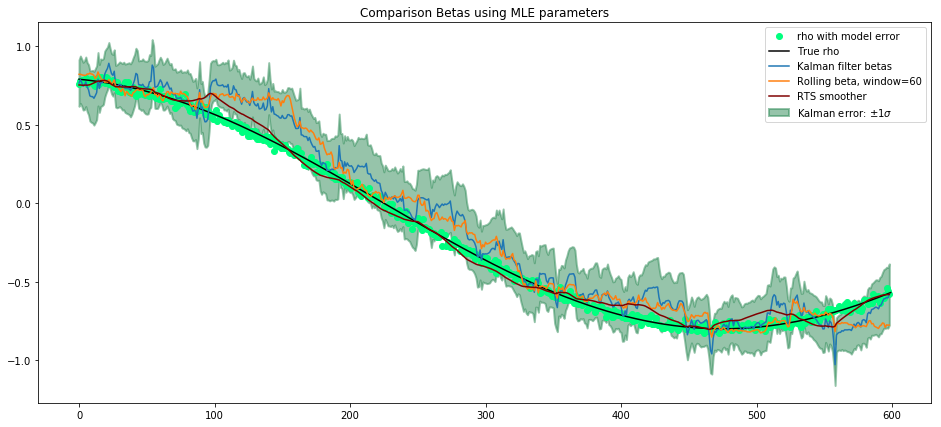

In [38]:
plt.figure(figsize=(16,7))
plt.plot(beta_nc[training_size:], color="springgreen", marker='o', linestyle="None", 
         label="rho with model error")
plt.plot(x[:(N-training_size)], rho_nc[training_size:], color="black", alpha=2, label="True rho")
plt.plot(betas_KF, label="Kalman filter betas")
plt.plot(rolling_beta2, label="Rolling beta, window={}".format(rolling_window))
plt.plot(betas_smooth, label="RTS smoother", color="maroon" )
plt.fill_between(x=range(len(betas_KF)) ,y1=betas_KF + np.sqrt(Ps_KF), y2=betas_KF - np.sqrt(Ps_KF), 
                 alpha=0.5, linewidth=2, color='seagreen', label="Kalman error: $\pm 1 \sigma$ ")
plt.legend(); plt.title("Comparison Betas using MLE parameters"); plt.show()

#### MSE:

In [39]:
print("MSE Rolling regression: ", np.mean((np.array(rolling_beta2) - rho_nc[training_size+1:]  )**2) )
print("MSE Kalman Filter: ", np.mean((betas_KF - rho_nc[training_size+1:])**2) )
print("MSE RTS Smoother: ", np.mean((betas_smooth - rho_nc[training_size+1:] )**2) )

MSE Rolling regression:  0.012824987450082674
MSE Kalman Filter:  0.013853234418804414
MSE RTS Smoother:  0.0023072793749055994


### Comments:

We see that the MSE of the filter is similar to the MSE of the rolling regression. However the Kalman filter does **not depend on the window size!**, whether the rolling regression output does!   
The presented result looks nice for a rolling regression with `rolling_window=60`, but if you try to increase it to `rolling_window=100` or more, you will notice a very bad performance.   
This behavior is the opposite of what we saw for a constant beta.

For the Kalman filter instead, we used the MLE estimated parameters, and therefore we didn't include any *ad hoc* parameters.

The smoothed beta has an incredibly small MSE! In general the smoothing approach has the purpose to remove the noise. It produces a very good estimate of the true value of beta (or rho).

<a id='sec3.2'></a>
## Example 2: Discontinuous behavior 

In the following example, I will give space to my imagination to create a highly irregular (but not too much) function.

The purpose is to test the behavior of the Kalman filter when the process model is completely wrong!     
Let us recall that we assumed (see notebook **5.1**) a beta process following a random walk:

$$ \beta_k = \beta_{k-1} + \eta_k \quad \text{with} \quad \eta_k \sim \mathcal{N}(0, \sigma^2_{\eta}) $$

A process with discontinuities cannot be well described by a random walk. 
Each discontinuity is interpreted as an extreme Gaussian event whose probability is negligible.    
However, we will see that the Kalman filter works well even in these circumstances. Although it takes some time to adjust to the new measurements (this time is inversely proportional to the process error $\sigma_{\eta}$)  

beta= 0.182378762240215  alpha= -0.002611655271123936
Auto Correlation =  0.18237764758337388


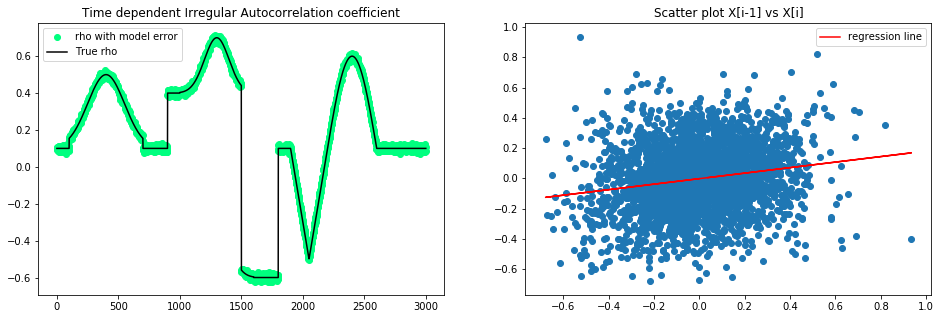

In [43]:
np.random.seed(seed=41) 
N = 3000
sig_mod3 = 0.01       # model error 
sig_meas3 = 0.2       # measure error

#############################   non constant, disconinuous, rho #############################################
x = np.array(range(N))
fig1 = np.concatenate([np.zeros(100), 0.4 * scp.signal.windows.gaussian(600,150), np.zeros(N-600-100)])
fig2 = np.concatenate([np.zeros(1000), 0.3 * scp.signal.windows.gaussian(600,100), np.zeros(N-600-1000)])
fig3 = np.concatenate([np.zeros(1500), -0.7+np.zeros(300), np.zeros(100), 
                          -0.6 * scp.signal.windows.triang(300), 
                          0.5*scp.signal.windows.cosine(400), np.zeros(N-100-400-300-1500-300)])
rho_nc = fig1 + fig2 + 0.1 + 0.3 * (1-np.heaviside(x-1500,1)) * np.heaviside(x-900,1) + fig3
#############################################################################################################
# Errors
err3 = ss.norm.rvs(loc=0, scale=sig_mod3, size=N-1)
err3 = err3 - err3.mean()
W3 = ss.norm.rvs(loc=0, scale=sig_meas3, size=N-1)
W3 = W3 - W3.mean()
beta_nc = rho_nc[1:] + err3

X_ar3 = np.zeros(N)                   # AR process
for i in range(N-1):
    X_ar3[i+1] = beta_nc[i] * X_ar3[i] + W3[i]

Y = X_ar3[1:]
X = X_ar3[:-1]
bb, aa, _, _, _ = ss.linregress(X,Y)    # Auto-regression  
print("beta=",bb," alpha=",aa)
print("Auto Correlation = ", np.corrcoef(Y,X)[0,1])

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(beta_nc, color="springgreen", marker='o', linestyle="None", 
         label="rho with model error")
ax1.plot(rho_nc, color="black", alpha=2, label="True rho")
ax1.legend(); ax1.set_title("Time dependent Irregular Autocorrelation coefficient") 
ax2.scatter(X, Y); ax2.set_title("Scatter plot X[i-1] vs X[i]") 
ax2.plot(X, aa + bb*X, color="r", label="regression line"); ax2.legend(); plt.show()

I collected all the code used in the Example 1 inside the function `plot_betas`.

MLE parameters
var_eta =  0.00020784793720369049
var_eps =  0.03706293023261817
MSE Rolling regression:  0.02177844447287357
MSE Kalman Filter:  0.02898173236875785
MSE RTS Smoother:  0.020064290895673888


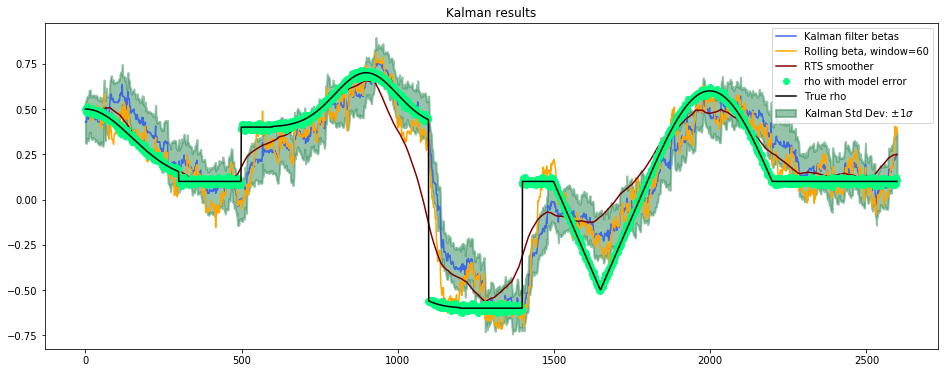

In [41]:
training_size=400
KF.plot_betas(X, Y, rho_nc, beta_nc, var_eta=None, training_size=training_size, rolling_window=60)

var_eta =  0.001
var_eps =  0.037933731310372074
MSE Rolling regression:  0.02177844447287357
MSE Kalman Filter:  0.02002213938559372
MSE RTS Smoother:  0.014151049676597334


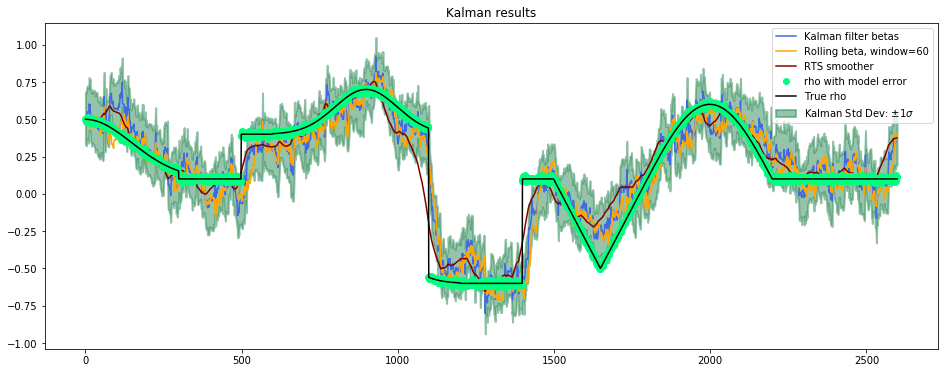

In [42]:
KF.plot_betas(X, Y, rho_nc, beta_nc, var_eta=0.001, training_size=training_size, rolling_window=60)

#### Comments:

The two plot above contain the results of the Kalman estimation compared with rollong regression and smoothed values.
- Smoothed values are always the best in terms of MSE. Of course they cannot be used "online" as they require the estimation of betas at each time in the dataset.
- In the first plot I used MLE parameters. The estimated value for `var_eta` is very close to the true value. However, this small values has problem in presence of jumps. For this reason the MSE is higher than the rolling regression one.
- To overcome this problem, in the second plot, I increased the parameter `var_eta` in order to make the filter more reactive to the jumps in the process. 
This example is important because it shows that in some situations the filter designer decisions matter. 
- Recall that when you choose a too small window in the rolling regression, the MSE instead of decreasing it increases. This is because the variance of beta increases.

One last tip to remember:     
Always compare the Kalman output with the rolling regression output, to get a better view of the functioning of the filter.